In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- EWJ (Japan)
- FXI (China Large-cap)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [3]:
root_dir = os.getcwd()

In [4]:
tickers = dict(
    SPY=dict(asset='equity'),
    EWJ=dict(asset='equity'),
    FXI=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond'),
    GLD=dict(asset='commodity'),
    UCO=dict(asset='commodity'),
    JO=dict(asset='commodity'),
    SGG=dict(asset='commodity'),
    PPLT=dict(asset='commodity'),
#     VXX=dict(asset='commodity'),
    UUP=dict(asset='fx'),
    FXE=dict(asset='fx'),
    FXB=dict(asset='fx'),
    FXY=dict(asset='fx'),
    CEW=dict(asset='fx'),
    BZF=dict(asset='fx'),
)

In [5]:
def vol_category_helper(row, *args):
    q0, q1, q2 = args[0], args[1], args[2]
    if row <= q0:
        return 0
    elif row <= q1:
        return 1
    elif row <= q2:
        return 2
    else:
        return 3

In [6]:
def beta_helper(row, *args):
    spy = args[0]
    try:
        return (row['corr'] * row['vol']) / spy.loc[row['Date'], 'vol']
    except KeyError:
        return np.nan

In [7]:
def corr_helper(row, *args):
    correl = args[0]
    try:
        return correl['SPY'][row.Date][row.ticker]
    except KeyError:
        return np.nan

In [64]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    for ticker in tickers.keys():
        df = pd.read_csv(root_dir+'/data/{}.csv'.format(ticker))
        df = df.replace({'null': np.nan})
        df['Close'] = pd.to_numeric(df['Close'])
        df['ticker'] = ticker
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date', False)
        df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
        df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)
        
        # Calculate vol on a 1 year rolling basis
        df['vol'] = df['pct_change'].rolling(252).std()
        df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
        df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
        df['asset_type'] = tickers[ticker]['asset']
        out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    
    gb_equity = pd.DataFrame()
    for key, grp in combined.groupby('ticker'):
        gb_equity[key] = grp['log_return']
    correl = gb_equity.rolling(252).corr()
    combined['corr'] = combined.apply(corr_helper, axis=1, args=(correl, ))
    combined['beta'] = combined.apply(beta_helper, axis=1, args=(combined.loc[combined.ticker == 'SPY'], ))
    combined['beta_abs'] = combined['beta'].abs()
    combined['ra_return'] = combined['log_return'] / combined['beta_abs']
    q1, q2, q3 = combined['vol'].quantile([.25, .5, .75])
    for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'ra_month_return'] = pd.rolling_sum(grp['ra_return'][::-1], window=22,
                                                                                    min_periods=22)[::-1]
        if grp['vol'].mean() <= q1:
            combined.loc[combined['ticker'] == key, 'category'] = 0
        elif grp['vol'].mean() <= q2:
            combined.loc[combined['ticker'] == key, 'category'] = 1
        elif grp['vol'].mean() <= q3:
            combined.loc[combined['ticker'] == key, 'category'] = 2
        else:
            combined.loc[combined['ticker'] == key, 'category'] = 4
    
    # Equities are placed into 4 vol categories based on their moment-in-time volatility relative to all historical
    # observed vols
#     combined['category'] = combined['vol'].apply(vol_category_helper, args=(q1, q2, q3))
    return out, combined
        

In [9]:
prices, combined = build_prices_dfs(tickers, 3)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()


In [10]:
gb_equity = pd.DataFrame()
for key, grp in combined.groupby('ticker'):
    gb_equity[key] = grp['log_return']
correl = gb_equity.rolling(252).corr()

In [13]:
correl.dropna()['SPY']

Date            
2011-01-06  AGG    -0.358438
            BZF     0.494403
            CEW     0.650465
            EFA     0.921512
            EMB     0.415370
            EWJ     0.723361
            FXB     0.425894
            FXE     0.455981
            FXI     0.777200
            FXY    -0.465796
            GLD     0.186861
            HYG     0.701942
            IJH     0.961223
            IJR     0.926238
            IWF     0.982687
            JO      0.215070
            LQD    -0.109701
            PPLT    0.540961
            SGG     0.214709
            SPY     1.000000
            UCO     0.718411
            UUP    -0.456428
            VIG     0.975174
            VWO     0.897177
2011-01-07  AGG    -0.358270
            BZF     0.494876
            CEW     0.650920
            EFA     0.921872
            EMB     0.416527
            EWJ     0.724036
                      ...   
2017-08-23  SGG     0.029432
            SPY     1.000000
            UCO     0.0855

In [17]:
combined.dropna().head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,vol,month_return,month_log_return,asset_type,corr,beta,ra_return,ra_month_return,category
Date,,,,,,,,,,,,,,,,,,,
2009-06-24,2009-06-24,52.3,52.39,51.53,51.799999,51.8,18000,SGG,0.034170,0.033599,0.024829,0.080744,0.077604,commodity,0.354243,0.305600,0.010323,0.025919,3
2009-06-25,2009-06-25,52.53,53.72,52.5,53.570000,53.57,21700,SGG,-0.016987,-0.017133,0.024840,0.051933,0.049350,commodity,0.356779,0.308425,-0.005229,0.017384,3
2009-06-26,2009-06-26,54.18,54.18,52.33,52.660000,52.66,11600,SGG,0.030573,0.030115,0.024903,0.067499,0.065061,commodity,0.357326,0.309618,0.009379,0.022208,3
2009-06-29,2009-06-29,53.5,54.53,53.16,54.270000,54.27,18800,SGG,-0.013636,-0.013729,0.024875,0.047068,0.045036,commodity,0.357611,0.309499,-0.004194,0.016088,3
2009-06-30,2009-06-30,54.18,54.31,52.66,53.529999,53.53,25600,SGG,0.002242,0.002239,0.024703,0.053129,0.051163,commodity,0.358923,0.308484,0.000746,0.017908,3


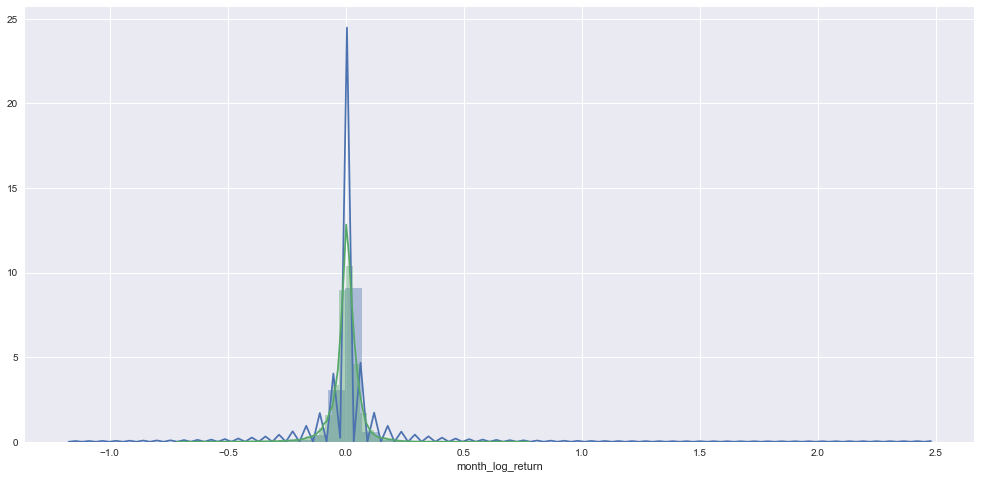

In [30]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.distplot(combined['ra_month_return'], ax=ax)
sns.distplot(combined['month_log_return'], ax=ax)

In [7]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [8]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

In [9]:
combined.groupby('ticker').mean()[['vol', 'category_enc']].sort_values('vol')

,vol,category_enc
ticker,,
AGG,0.003143,1
LQD,0.005037,1
CEW,0.005288,1
UUP,0.005639,1
FXE,0.006283,1
FXB,0.006298,1
FXY,0.006887,1
EMB,0.007078,3
HYG,0.008003,3


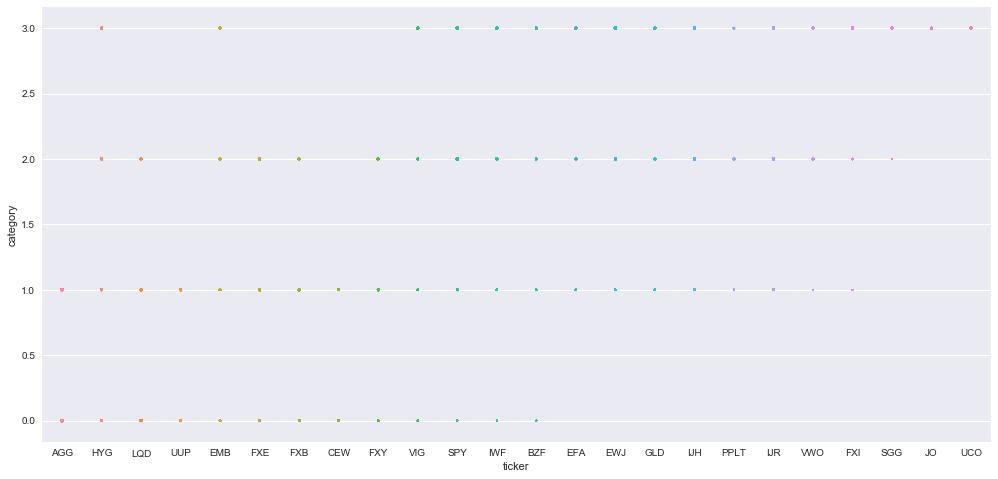

In [21]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined.sort_values('vol')['vol'].values*1000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [11]:
combined = combined.dropna()

In [12]:
combined.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,vol,month_return,month_log_return,asset_type,category,category_enc,asset_type_enc,security_enc
Date,,,,,,,,,,,,,,,,,
2000-05-26,45.687500,45.687500,45.687500,45.687500,36.954700,40000,IJH,0.038988,0.038247,0.013328,0.077453,0.074767,equity,2,0,0,0
2000-05-30,47.187500,47.468750,47.187500,47.468750,38.395473,104200,IJH,-0.001646,-0.001647,0.013328,0.043226,0.041270,equity,2,0,0,0
2000-05-31,47.390621,47.390621,47.390621,47.390621,38.332291,400,IJH,0.018134,0.017971,0.013328,0.025604,0.023461,equity,2,0,0,0
2000-06-01,47.937500,48.250000,47.937500,48.250000,39.027409,20400,IJH,0.038860,0.038124,0.013328,0.020836,0.018767,equity,2,0,0,0
2000-06-02,50.296879,50.328121,50.046879,50.125000,40.544010,83600,IJH,-0.007637,-0.007666,0.013328,-0.030578,-0.031990,equity,2,0,0,0


In [13]:
groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map

array([0, 1, 2, 1, 2, 1, 2, 0, 3, 2, 0, 1, 3, 0, 2, 1, 1, 0, 2, 3, 3, 1, 3,
       3])

In [14]:
train, test = train_test_split(combined, test_size=.3)

In [20]:
np.unique(sec_category_map)

array([0, 1, 2, 3])

In [77]:
prices, combined = build_prices_dfs(tickers, 3)

fast_window = 7
slow_window = 25
for ticker in combined['ticker'].unique():
    combined.loc[combined['ticker'] == ticker, 'fast'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(fast_window).mean()
        
    combined.loc[combined['ticker'] == ticker, 'slow'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
combined['momentum'] = pd.to_numeric((combined['fast'] - combined['slow']) / combined['slow'])
combined = combined.dropna()

category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)

n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.3)

with pm.Model() as model:
    # Hyperpriors for slope based on vol classification
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
    # Hyperpriors for slope, derived from vol_classification, used for individual security calculation
    a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
    a_sec_sd = pm.Uniform('a_security_sd', 1, 5)
        
    a_sec = pm.Normal('a_security', mu=a_category[sec_category_map], sd=a_sec_sd, shape=n_securities)
#     a_beta = pm.Normal('a_beta', mu=0, sd=5)

    # Calculate the intercept for each security independently, nothing fancy here
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = (((train['momentum'].values * a_sec[train['security_enc'].values]) +
             b_sec[train['security_enc'].values]) / train['beta_abs'])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['ra_month_return'].values)
    mom_trace = pm.sample(500, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
100%|██████████| 500/500 [4:21:46<00:00, 20.10s/it]


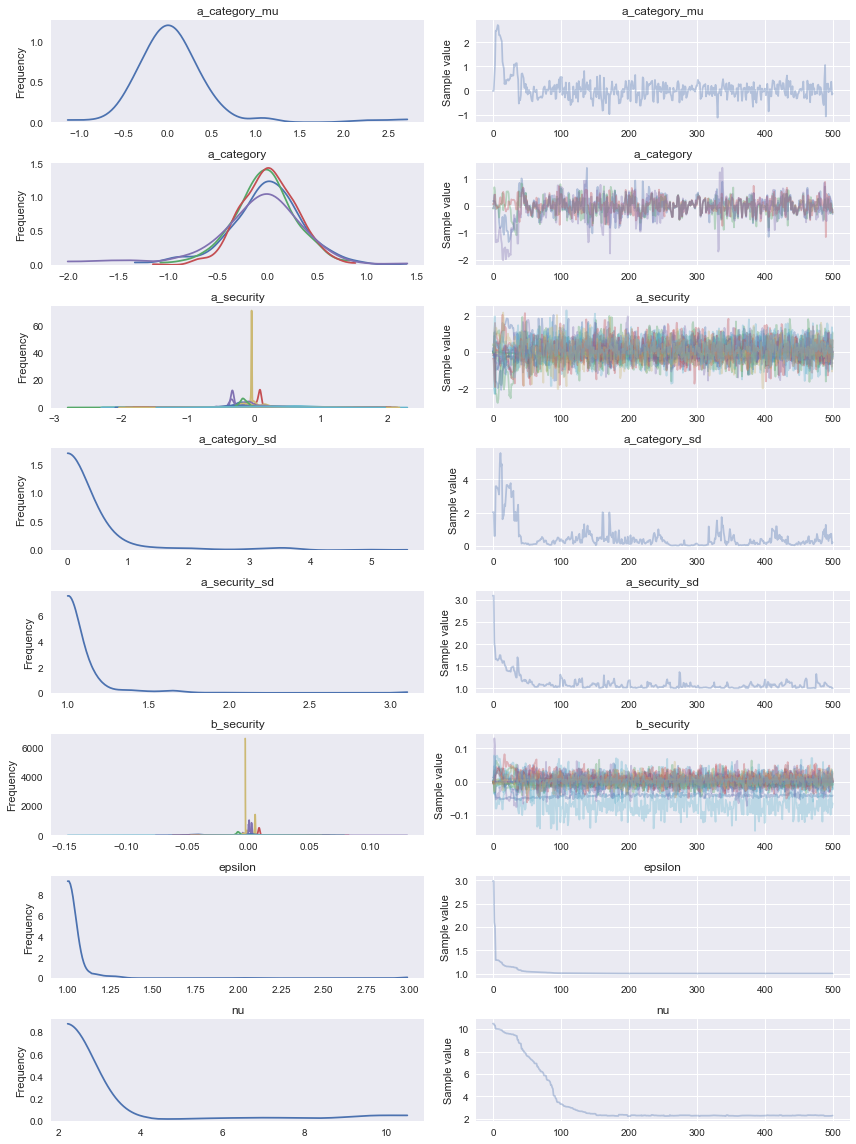

In [79]:
pm.traceplot(mom_trace);

In [80]:
test.head()[['ticker', 'beta']]

,ticker,beta
Date,,
2007-12-18,GLD,0.402500
2014-08-04,CEW,0.217819
2011-01-11,FXY,-0.270719
2010-06-18,FXB,0.247813
2010-06-09,VWO,1.345785


In [85]:
def calc_prediction_helper(row, *args):
    if args[0] == 'momentum':
        a = ((row.momentum * mom_trace['a_security'][:, row.security_enc] + 
             mom_trace['b_security'][:, row.security_enc]) / row.beta_abs)
    elif args[0] == 'value':
        a = ((row.value * val_trace['a_security'][:, row.security_enc]) + 
             (row.beta_abs * val_trace['a_beta']) +
             val_trace['b_security'][:, row.security_enc])
    return np.mean(a > 0)

In [86]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1, args=('momentum', ))

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


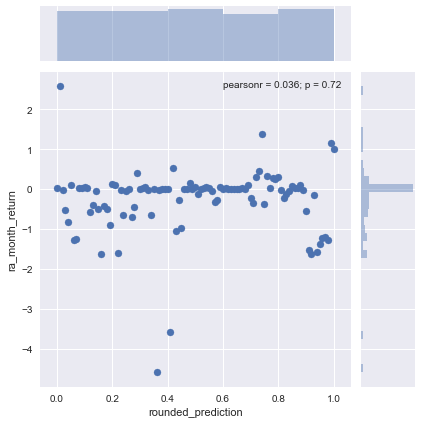

In [87]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['ra_month_return'].index,
              test.groupby('rounded_prediction').mean()['ra_month_return'])

In [48]:
for key, grp in test.groupby('category'):
    low, high = grp['prediction'].quantile([.25, .75])
    print('Avg. return on long positions for category {}: {}'.format(key, grp.loc[grp.prediction >= high, 'month_log_return'].mean()))
    print('Avg. return on short positions for category {}: {}\n'.format(key, grp.loc[grp.prediction <= low, 'month_log_return'].mean()))

Avg. return on long positions for category 0.0: 0.0015527804460015169
Avg. return on short positions for category 0.0: -0.0020021356376612003

Avg. return on long positions for category 1.0: 0.005737263990039788
Avg. return on short positions for category 1.0: -0.006899417063607135

Avg. return on long positions for category 2.0: 0.00768998560796663
Avg. return on short positions for category 2.0: -0.0007120844159685645

Avg. return on long positions for category 4.0: 0.014233396276861996
Avg. return on short positions for category 4.0: -0.0180685819562564



In [49]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = mom_trace['a_security'][:, i]
    ticker_to_b[t] = mom_trace['b_security'][:, i]

In [50]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(SGG=[-0.0990441400655, 1.87571065204, 1.53768678895, 1.50982457117, 0.935739651019, -2.15923727881, -2.15923727881, -2.06455500933, -0.119169593281, 0.155929091439, 0.155929091439, -0.158994641369, 0.127384346149, -0.0964001429323, 0.307616011975, 0.307616011975, -0.0601108368271, 0.447155112614, -0.43388577576, -0.507728278671, -0.507728278671, -0.297692537232, 0.0746942148253, -0.013876536069, 0.172546452206, -0.149736913182, 0.442617410831, 0.0213024945722, 0.136738714423, 0.186254457081, 0.633379766105, -0.135988182844, 0.185062796745, 0.0188479891821, 0.537489127302, 0.0601211433989, 0.0549313346116, 0.0772273388329, 0.0772273388329, -0.00801677466656, 1.00671363138, 0.599033162574, 0.0235514104809, 0.196290801747, -0.341596983468, 0.437420970063, 0.437420970063, 0.242204930426, -0.0907063465331, -0.198059553804, 0.187175970038, 0.477731125701, -0.472587279205, -0.472587279205, 0.0646846894219, 0.278632310165, -0.345376397862, -0.345376397862, -0.328353737256, 0.59939464126, 

In [51]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(SGG=[-0.00388761954875, -0.164191636338, -0.148432875476, -0.106859530736, -0.0697532921027, 0.14084995424, 0.14084995424, 0.136275905175, 0.00373361508819, -0.00436603928566, -0.00436603928566, 0.0120736010596, 0.000730129707627, -0.0176309342996, -0.00491568425513, -0.00491568425513, -0.0118712750897, -0.00513788820369, -0.00722325651298, -0.0264846838586, -0.0264846838586, -0.010851626611, -0.00782782889033, -0.0029716158216, -0.0154064705724, -0.00238270154296, -0.0119352456446, 0.0151768049826, -0.0399684535376, 0.0188339147827, 0.0294740949543, -0.0498307174071, 0.0245857975951, -0.0335666052543, 0.0321072004635, -0.0619428895774, -0.0648577863623, 0.0544309835175, 0.0544309835175, -0.0298824214379, 0.0155464457222, -0.00156310344447, -0.0186988481519, -0.0280348617483, -0.0156231993837, -0.0291012852779, -0.0291012852779, -0.0309571151015, -0.0516613993255, -0.0756379802493, -0.0747538959132, -0.072489061246, -0.000191851482879, -0.000191851482879, -0.0185057209708, -0.0223

In [53]:
s = '['
for a in mom_trace['a_beta']:
    s += str(a) + ', '
s = s[:-2]
s += ']'
print(s)

[-0.00205191280071, 0.00140859789605, 0.00213703421077, -0.00245504498072, -0.00670730274752, -0.0245692102728, -0.0245692102728, -0.0225024701847, -0.00466659956605, 5.80876756411e-05, 5.80876756411e-05, 0.00883768306833, 0.0178366259992, 0.0214916483032, 0.02476503835, 0.02476503835, 0.023529257624, 0.0170232653708, 0.0135510868741, 0.012979707008, 0.012979707008, 0.0163360576402, 0.0182864717623, 0.0243275395462, 0.03262720286, 0.0447897543372, 0.0473240438301, 0.0376302432799, 0.041340098475, 0.0322569839529, 0.0298490899511, 0.0331137125813, 0.00648378050441, 0.0259480581171, 0.0244060146872, 0.00713276155861, 0.00962087136908, 0.0326215766812, 0.0326215766812, 0.031252298339, 0.0312656260216, 0.050048746508, 0.0580039227587, 0.0619881053731, 0.0753825966364, 0.0842285927456, 0.0842285927456, 0.0850095327499, 0.0875669003867, 0.0864379516772, 0.0860663142937, 0.0848981713184, 0.0771498988098, 0.0771498988098, 0.0697806412171, 0.0763970285244, 0.0616992256633, 0.0616992256633, 0.06

# Value Regression

In [54]:
prices, combined = build_prices_dfs(tickers, 3)

slow_window = 252 * 3
for ticker in combined['ticker'].unique():
    combined.loc[combined['ticker'] == ticker, 'slow'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
combined['value'] = pd.to_numeric((combined['Close'] - combined['slow']) / combined['slow'])
combined = combined.dropna()

category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)

n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.3)

with pm.Model() as model:
    # Hyperpriors for slope based on vol classification
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
    # Hyperpriors for slope, derived from vol_classification, used for individual security calculation
    a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
    a_sec_sd = pm.Uniform('a_security_sd', 1, 5)
        
    a_sec = pm.Normal('a_security', mu=a_category[sec_category_map], sd=a_sec_sd, shape=n_securities)
    a_beta = pm.Normal('a_beta', mu=0, sd=5)

    # Calculate the intercept for each security independently, nothing fancy here
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = ((train['value'].values * a_sec[train['security_enc'].values]) +
             (train['beta_abs'].values * a_beta) + 
             b_sec[train['security_enc'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['ra_month_return'].values)
    val_trace = pm.sample(250, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
100%|██████████| 250/250 [19:20<00:00,  4.89s/it]


In [55]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1, args=('value', ))

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


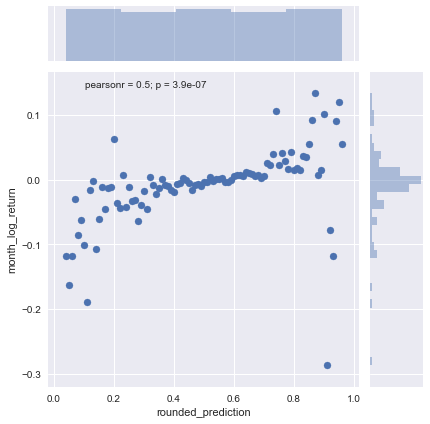

In [56]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['month_log_return'].index, test.groupby('rounded_prediction').mean()['month_log_return'])

In [57]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = val_trace['a_security'][:, i]
    ticker_to_b[t] = val_trace['b_security'][:, i]

In [58]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(SGG=[-0.000642378661612, -0.000642378661612, 0.102905388307, 0.0955848899639, 0.0349576900345, 0.0164560164134, 0.0297306210727, 0.0741592095645, 0.135675254466, 0.149640324104, 0.143486758414, 0.274369915283, 0.286487860189, 0.25640369715, 0.226896073065, 0.226896073065, 0.274739393275, 0.25920648334, 0.252129847304, 0.181005442288, -0.409217325565, -0.409217325565, -0.380337763554, -0.0607406976594, -0.0760820862935, -0.0760820862935, -0.0769893861575, -0.0349899133008, -0.137461229903, 0.0619720332928, 0.0441998505853, -0.117557361116, 0.0258394057301, -0.120556199607, -0.185549872786, -0.138948470921, 0.0247355897667, -0.112070714669, -0.100612153859, 0.0386187020173, -0.111641138566, -0.111641138566, 0.0669546887243, -0.132082782864, -0.244580681247, -0.244580681247, -0.260595291439, -0.221305631114, 0.0351261969965, 0.0337822472048, -0.189726836045, 0.0518675119813, -0.0388885506688, 0.0805042333027, -0.123380031016, 0.0139682137728, -0.093542034829, 0.0303647658726, -0.1119

In [59]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(SGG=[0.00474437678656, 0.00474437678656, -0.00554056483763, -0.00633848154152, -0.0144855264028, -0.0106323681745, -0.0118869461512, -0.00708243799555, 0.00628948721039, 0.00376410936005, 0.00450570968579, 0.0105175402657, 0.00118986020898, -0.0109167154207, -0.0318666918825, -0.0318666918825, -0.0513752171582, -0.0771910154998, -0.0920237484797, -0.105930863774, -0.00545378766314, -0.00545378766314, -0.0238375955909, -0.0194497234259, 0.00502438545953, 0.00502438545953, -0.0675775616743, 0.00197414565529, -0.00983615698526, 0.0320833110941, -0.00242001007905, 0.000755509210482, 0.0116453145915, -0.00917369160873, -0.0033198512213, -0.0284589472039, 0.0109561615356, -0.0264188092153, -0.0116282603582, -0.0430845684012, 0.0320569553114, 0.0320569553114, -0.0242798067378, -0.0747854585809, -0.0589470819259, -0.0589470819259, -0.0705469591563, -0.0570789028839, -0.0261731195025, -0.0270103198138, -0.0387884398697, -0.0159446116313, 0.00841430769956, -0.0189980589272, -0.0732954586886

In [60]:
s = '['
for a in mom_trace['a_beta']:
    s += str(a) + ', '
s = s[:-2]
s += ']'
print(s)

[-0.00205191280071, 0.00140859789605, 0.00213703421077, -0.00245504498072, -0.00670730274752, -0.0245692102728, -0.0245692102728, -0.0225024701847, -0.00466659956605, 5.80876756411e-05, 5.80876756411e-05, 0.00883768306833, 0.0178366259992, 0.0214916483032, 0.02476503835, 0.02476503835, 0.023529257624, 0.0170232653708, 0.0135510868741, 0.012979707008, 0.012979707008, 0.0163360576402, 0.0182864717623, 0.0243275395462, 0.03262720286, 0.0447897543372, 0.0473240438301, 0.0376302432799, 0.041340098475, 0.0322569839529, 0.0298490899511, 0.0331137125813, 0.00648378050441, 0.0259480581171, 0.0244060146872, 0.00713276155861, 0.00962087136908, 0.0326215766812, 0.0326215766812, 0.031252298339, 0.0312656260216, 0.050048746508, 0.0580039227587, 0.0619881053731, 0.0753825966364, 0.0842285927456, 0.0842285927456, 0.0850095327499, 0.0875669003867, 0.0864379516772, 0.0860663142937, 0.0848981713184, 0.0771498988098, 0.0771498988098, 0.0697806412171, 0.0763970285244, 0.0616992256633, 0.0616992256633, 0.06

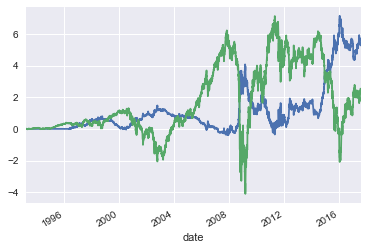

In [454]:
combined.groupby('date').sum()['bt_return'].cumsum().plot()
combined.groupby('date').sum()['log_return'].cumsum().plot()

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

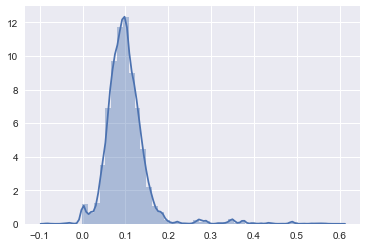

In [319]:
sns.distplot(trace['a_security'][:, 10])

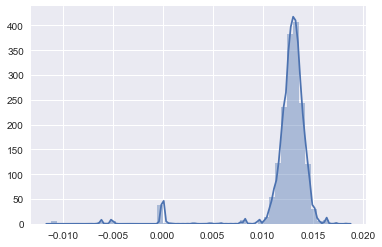

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
